In [456]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram,linkage
from sklearn.cluster import AgglomerativeClustering,KMeans,DBSCAN
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder,MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors



# **Data Inspection and Initial Exploration and Enhancing the memory**


In [458]:
df = pd.read_csv('book_ratings.csv')
df.drop('Book-Rating',axis=1,inplace=True)

In [459]:
df.head()

ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

            Book-Author  Year-Of-Publication                   Publisher  \
0    Mark P. O. Morford               2002.0     Oxford University Press   
1  Richard Bruce Wright               2001.0       HarperFlamingo Canada   
2          Carlo D'Este               1991.0             HarperPerennial   
3      Gina Bari Kolata               1999.0        Farrar Straus Giroux   
4       E. J. W. Barber               1999.0  W. W. Norton &amp; Company   

   User-ID   Age      City       State Country  
0        2  18.0  stockton  california     usa  
1        8  32.0   timmins     ontario  canada  
2        8  32.0   timmins     ontario  canada  
3        8  32.0   timmins     ontario  canada  
4        8  32.0   timmins     ontario  canada

In [460]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031028 entries, 0 to 1031027
Data columns (total 10 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   ISBN                 1031028 non-null  object 
 1   Book-Title           1031028 non-null  object 
 2   Book-Author          1031027 non-null  object 
 3   Year-Of-Publication  1031028 non-null  float64
 4   Publisher            1031028 non-null  object 
 5   User-ID              1031028 non-null  int64  
 6   Age                  1031028 non-null  float64
 7   City                 1016929 non-null  object 
 8   State                1008235 non-null  object 
 9   Country              995660 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 78.7+ MB


In [461]:
df['Year-Of-Publication'] = df['Year-Of-Publication'].astype(int)
df['Age'] = df['Age'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031028 entries, 0 to 1031027
Data columns (total 10 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   ISBN                 1031028 non-null  object
 1   Book-Title           1031028 non-null  object
 2   Book-Author          1031027 non-null  object
 3   Year-Of-Publication  1031028 non-null  int32 
 4   Publisher            1031028 non-null  object
 5   User-ID              1031028 non-null  int64 
 6   Age                  1031028 non-null  int32 
 7   City                 1016929 non-null  object
 8   State                1008235 non-null  object
 9   Country              995660 non-null   object
dtypes: int32(2), int64(1), object(7)
memory usage: 70.8+ MB


In [462]:
df.shape
print("number of rows ",df.shape[0])
print("number of columns ",df.shape[1])
##over million recored
df=df.iloc[:20000,:]

number of rows  1031028
number of columns  10


# **Handling Missing Values and Dupplicated recored and Dropping the UserID&ISBN**

In [464]:
df.isnull().sum()/df.shape[0]*100

ISBN                    0.000
Book-Title              0.000
Book-Author             0.000
Year-Of-Publication     0.000
Publisher               0.000
User-ID                 0.000
Age                     0.000
City                   55.710
State                  55.710
Country                56.165
dtype: float64

In [465]:
df['City'].fillna(df['City'].mode()[0],inplace=True)
df['State'].fillna(df['State'].mode()[0],inplace=True)
df['Book-Author'].fillna(df['Book-Author'].mode()[0],inplace=True)
df['Country'].fillna(df['Country'].mode()[0],inplace=True)

C:\Users\Owner\AppData\Local\Temp\ipykernel_30212\1467624954.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['City'].fillna(df['City'].mode()[0],inplace=True)
C:\Users\Owner\AppData\Local\Temp\ipykernel_30212\1467624954.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

In [466]:
df.isnull().sum()/df.shape[0]*100

ISBN                   0.0
Book-Title             0.0
Book-Author            0.0
Year-Of-Publication    0.0
Publisher              0.0
User-ID                0.0
Age                    0.0
City                   0.0
State                  0.0
Country                0.0
dtype: float64

In [467]:
df.duplicated().sum()


0

In [468]:
df.drop(['ISBN','User-ID'],axis=1,inplace=True)

# **Outlier Detection and Treatment**

In [470]:
numerical_columns = df.select_dtypes(include=['int32']).columns

In [471]:
print("Numerical Columns:", numerical_columns)

Numerical Columns: Index(['Year-Of-Publication', 'Age'], dtype='object')


In [472]:
# Determine the number of numerical columns
num_columns = len(numerical_columns)

# Calculate the number of rows needed (using integer division and ceiling if necessary)
rows = (num_columns // 2) + (num_columns % 2)

# Create the subplots with enough axes
fig, axes = plt.subplots(rows, 2, figsize=(10, 5 * rows))  # Adjust figure size
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Plot each numerical column in a boxplot
for i, col in enumerate(numerical_columns):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()


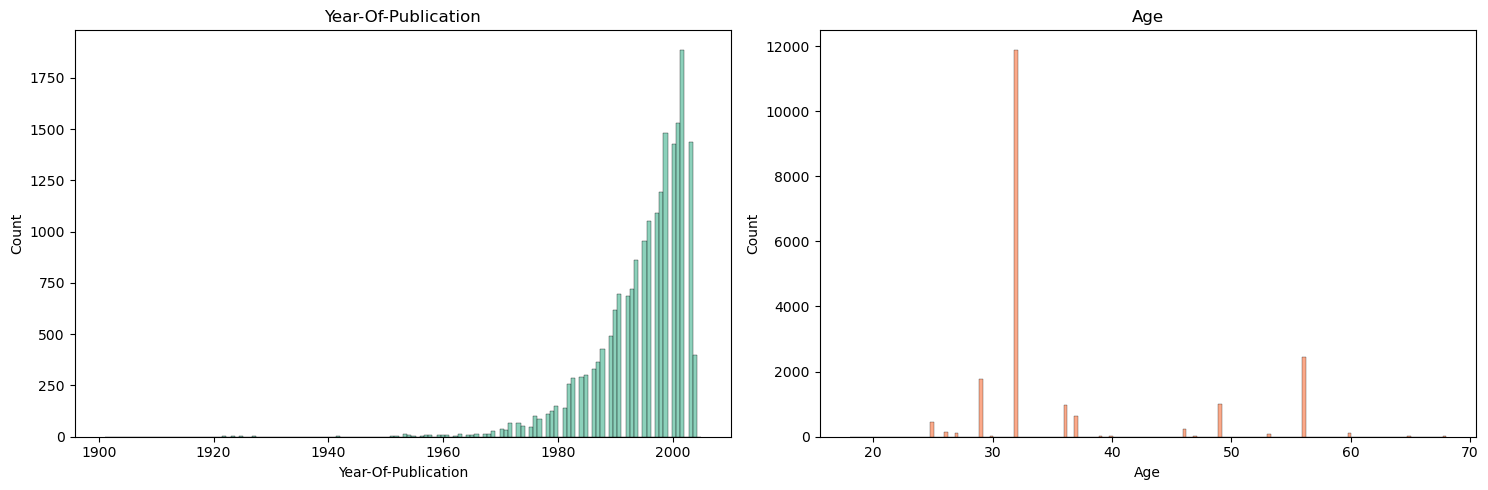

In [473]:
palette = sns.color_palette("Set2", len(numerical_columns))  # Choose any palette like 'Set1', 'coolwarm', etc.
fig, axes = plt.subplots(1, len(numerical_columns), figsize=(15, 5))

for i, col in enumerate(numerical_columns):
    sns.histplot(df[col], ax=axes[i], color=palette[i])  # Use the color palette for each histogram
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

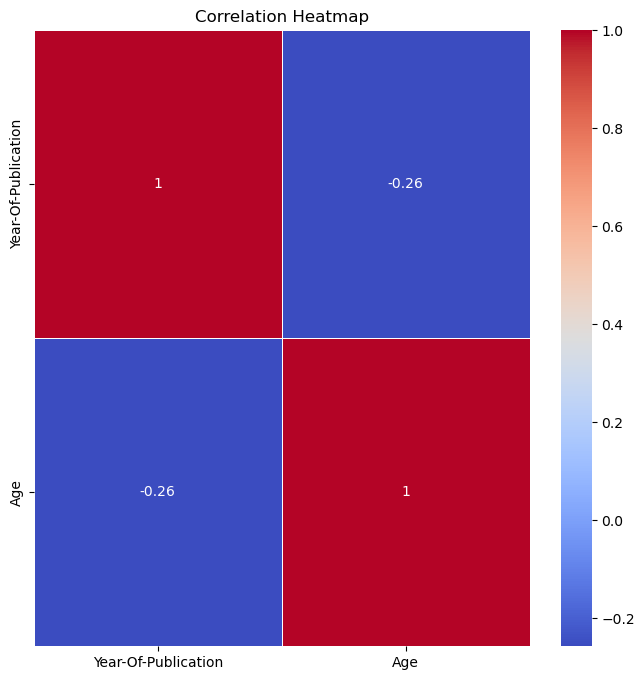

In [474]:
plt.figure(figsize=(8, 8))
sns.heatmap(df[numerical_columns].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

C:\Users\Owner\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
C:\Users\Owner\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
C:\Users\Owner\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
C:\Users\Owner\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)


<Figure size 800x800 with 0 Axes>

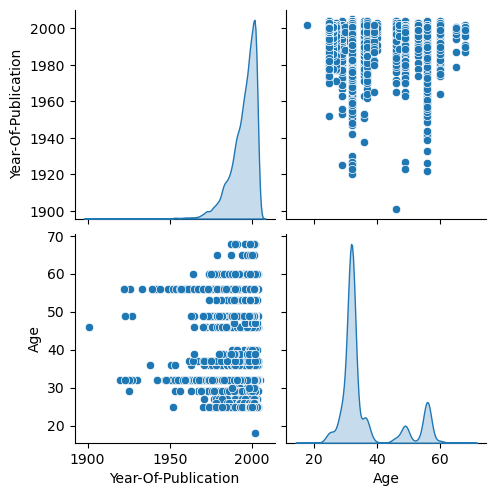

In [475]:
plt.figure(figsize=(8, 8))
sns.pairplot(df[numerical_columns],diag_kind='kde', palette='coolwarm')
plt.show()

In [476]:
for col in numerical_columns:
  q1=df[col].quantile(0.25)
  q3=df[col].quantile(0.75)
  iqr=q3-q1
  lower_bound=q1-1.5*iqr
  upper_bound=q3+1.5*iqr
  outliers=df[(df[col]<lower_bound) | (df[col]>upper_bound)]
  print(f"Column: {col}")
  print(f"Number of lower outliers: {outliers[outliers[col] < lower_bound].shape[0]}")
  print(f"Number of upper outliers: {outliers[outliers[col] > upper_bound].shape[0]}")
  num_outliers = outliers.shape[0] / df.shape[0]
  print(f"Proportion of outliers in {col}: {round(num_outliers, 3)}")
  print("*********************************************************")

Column: Year-Of-Publication
Number of lower outliers: 499
Number of upper outliers: 0
Proportion of outliers in Year-Of-Publication: 0.025
*********************************************************
Column: Age
Number of lower outliers: 461
Number of upper outliers: 3946
Proportion of outliers in Age: 0.22
*********************************************************


In [477]:
##There are a few outliers in the dataset for the year, but when it comes to age, we have a moderate quantity.
##Therefore, I filtered the dataframe to remove the noise from the age column and compared the effects of the algorithm
#both with and without this adjustment.

In [478]:
q1 = df['Age'].quantile(0.25)
q3 = df['Age'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Creating a DataFrame without the outliers in 'Age'
df_no_outliers = df[(df['Age'] >= lower_bound) & (df['Age'] <= upper_bound)]
df_no_outliers.head()

Book-Title           Book-Author  \
1                                       Clara Callan  Richard Bruce Wright   
2                               Decision in Normandy          Carlo D'Este   
3  Flu: The Story of the Great Influenza Pandemic...      Gina Bari Kolata   
4                             The Mummies of Urumchi       E. J. W. Barber   
5                             The Kitchen God's Wife               Amy Tan   

   Year-Of-Publication                   Publisher  Age     City    State  \
1                 2001       HarperFlamingo Canada   32  timmins  ontario   
2                 1991             HarperPerennial   32  timmins  ontario   
3                 1999        Farrar Straus Giroux   32  timmins  ontario   
4                 1999  W. W. Norton &amp; Company   32  timmins  ontario   
5                 1991            Putnam Pub Group   32  timmins  ontario   

  Country  
1  canada  
2  canada  
3  canada  
4  canada  
5  canada

# **Checking Data Consistency and Visualizing Categorical Distributions**

In [480]:
categorical_columns = df.select_dtypes(include=['object']).columns

In [481]:
#The categorical columns have a highly imbalanced distribution of unique values. 
#A few values are very frequent, while many appear rarely. 
# This imbalance could cause issues during encoding (e.g., One-Hot Encoding) or visualization, leading to memory inefficiencies or skewed results.
#I got   the top 10 most frequent to highlight this imbalance. 

In [482]:
for col in categorical_columns:
    print(df[col].value_counts())

Book-Title
The Kitchen God's Wife                                                                                17
Clara Callan                                                                                          14
Bridget Jones's Diary                                                                                 13
The Red Tent (Bestselling Backlist)                                                                   11
Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It    11
                                                                                                      ..
El Evangelio Segun Jesucristo (Punto De Lectura, 8/3)                                                  1
La balsa de piedra                                                                                     1
Marrow                                                                                                 1
By Reason of Insanity                       

In [483]:
for col in categorical_columns:
  print(f"Column: {col}")
  print(f"Number of unique values: {df[col].nunique()}")
  print("*********************************************************")

Column: Book-Title
Number of unique values: 16453
*********************************************************
Column: Book-Author
Number of unique values: 9654
*********************************************************
Column: Publisher
Number of unique values: 2608
*********************************************************
Column: City
Number of unique values: 30
*********************************************************
Column: State
Number of unique values: 21
*********************************************************
Column: Country
Number of unique values: 2
*********************************************************


In [484]:
# Get top 10 books, authors, and publishers
top_books_list = df['Book-Title'].value_counts().head(10).index.tolist()
top_authors_list = df['Book-Author'].value_counts().head(10).index.tolist()
top_publishers_list = df['Publisher'].value_counts().head(10).index.tolist()


In [485]:
top_books_list = df_no_outliers['Book-Title'].value_counts().head(10).index.tolist()
top_authors_list = df_no_outliers['Book-Author'].value_counts().head(10).index.tolist()
top_publishers_list = df_no_outliers['Publisher'].value_counts().head(10).index.tolist()


In [486]:
# Replace non-top books with "Other"
df['Book-Title'] = df['Book-Title'].apply(lambda x: x if x in top_books_list else 'Other')

# Replace non-top authors with "Other"
df['Book-Author'] = df['Book-Author'].apply(lambda x: x if x in top_authors_list else 'Other')

# Replace non-top publishers with "Other"
df['Publisher'] = df['Publisher'].apply(lambda x: x if x in top_publishers_list else 'Other')


In [487]:
# Replace non-top books with "Other"
df_no_outliers['Book-Title'] = df_no_outliers['Book-Title'].apply(lambda x: x if x in top_books_list else 'Other')

# Replace non-top authors with "Other"
df_no_outliers['Book-Author'] = df_no_outliers['Book-Author'].apply(lambda x: x if x in top_authors_list else 'Other')

# Replace non-top publishers with "Other"
df_no_outliers['Publisher'] = df_no_outliers['Publisher'].apply(lambda x: x if x in top_publishers_list else 'Other')



C:\Users\Owner\AppData\Local\Temp\ipykernel_30212\1501067556.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers['Book-Title'] = df_no_outliers['Book-Title'].apply(lambda x: x if x in top_books_list else 'Other')
C:\Users\Owner\AppData\Local\Temp\ipykernel_30212\1501067556.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers['Book-Author'] = df_no_outliers['Book-Author'].apply(lambda x: x if x in top_authors_list else 'Other')
C:\Users\Owner\AppData\Local\Temp\ipykernel_30212\15

In [488]:
categorical_columns = df.select_dtypes(include=['object']).columns

In [489]:
for col in categorical_columns:
    print(df[col].value_counts())

Book-Title
Other                                  19887
The Kitchen God's Wife                    17
Clara Callan                              14
Bridget Jones's Diary                     13
The Red Tent (Bestselling Backlist)       11
The Secret Life of Bees                   11
The Hundred Secret Senses                 11
The Lovely Bones: A Novel                 10
White Oleander : A Novel                  10
To Kill a Mockingbird                      8
The Bonesetter's Daughter                  8
Name: count, dtype: int64
Book-Author
Other                 19385
Stephen King            112
James Patterson          70
Nora Roberts             68
Tom Clancy               59
John Grisham             57
Mary Higgins Clark       56
Agatha Christie          54
Janet Evanovich          50
Peter David              47
Danielle Steel           42
Name: count, dtype: int64
Publisher
Other                       16321
Ballantine Books              561
Warner Books                  434
Pocket    

In [490]:
categorical_columns = df.select_dtypes(include=['object']).columns
print(categorical_columns)

Index(['Book-Title', 'Book-Author', 'Publisher', 'City', 'State', 'Country'], dtype='object')


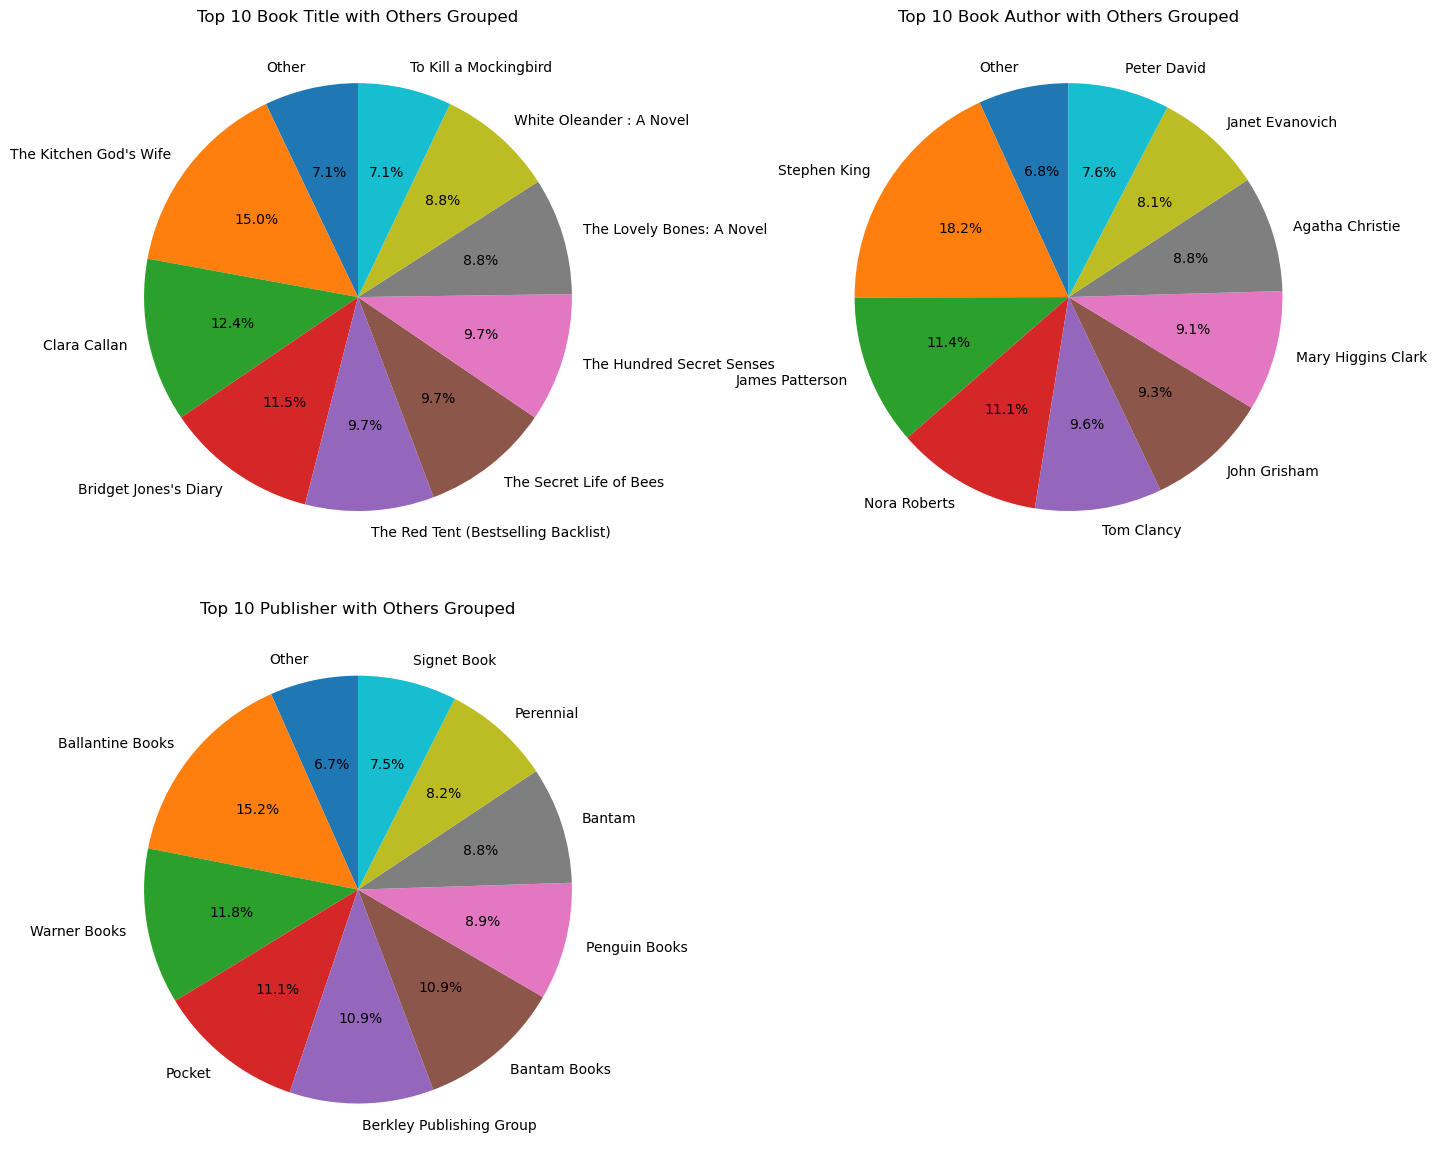

In [491]:
categorical_columns = ['Book-Title', 'Book-Author', 'Publisher']  
top_n = 10
n_columns = len(categorical_columns)
rows = (n_columns + 1) // 2  
fig, axs = plt.subplots(rows, 2, figsize=(14, 12))  
axs = axs.flatten()

# Loop over each categorical column and create a pie chart
for i, category in enumerate(categorical_columns):
    # Get the top 10 values and sum the rest as "Other"
    top_values = df[category].value_counts().nlargest(top_n)
    other_values = df[category].value_counts().iloc[top_n:].sum()  # Sum all values beyond top_n
    if other_values > 0:  # Only add 'Other' if there are values to group
        top_values['Other'] = other_values

    # Plot the pie chart in the appropriate subplot
    ax = axs[i]  # Since axs is flattened, you can now use a single index
    ax.pie(top_values, labels=top_values.index, autopct='%1.1f%%', startangle=90)
    
    # Set the title for each pie chart
    ax.set_title(f'Top 10 {category.replace("-", " ")} with Others Grouped')

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()

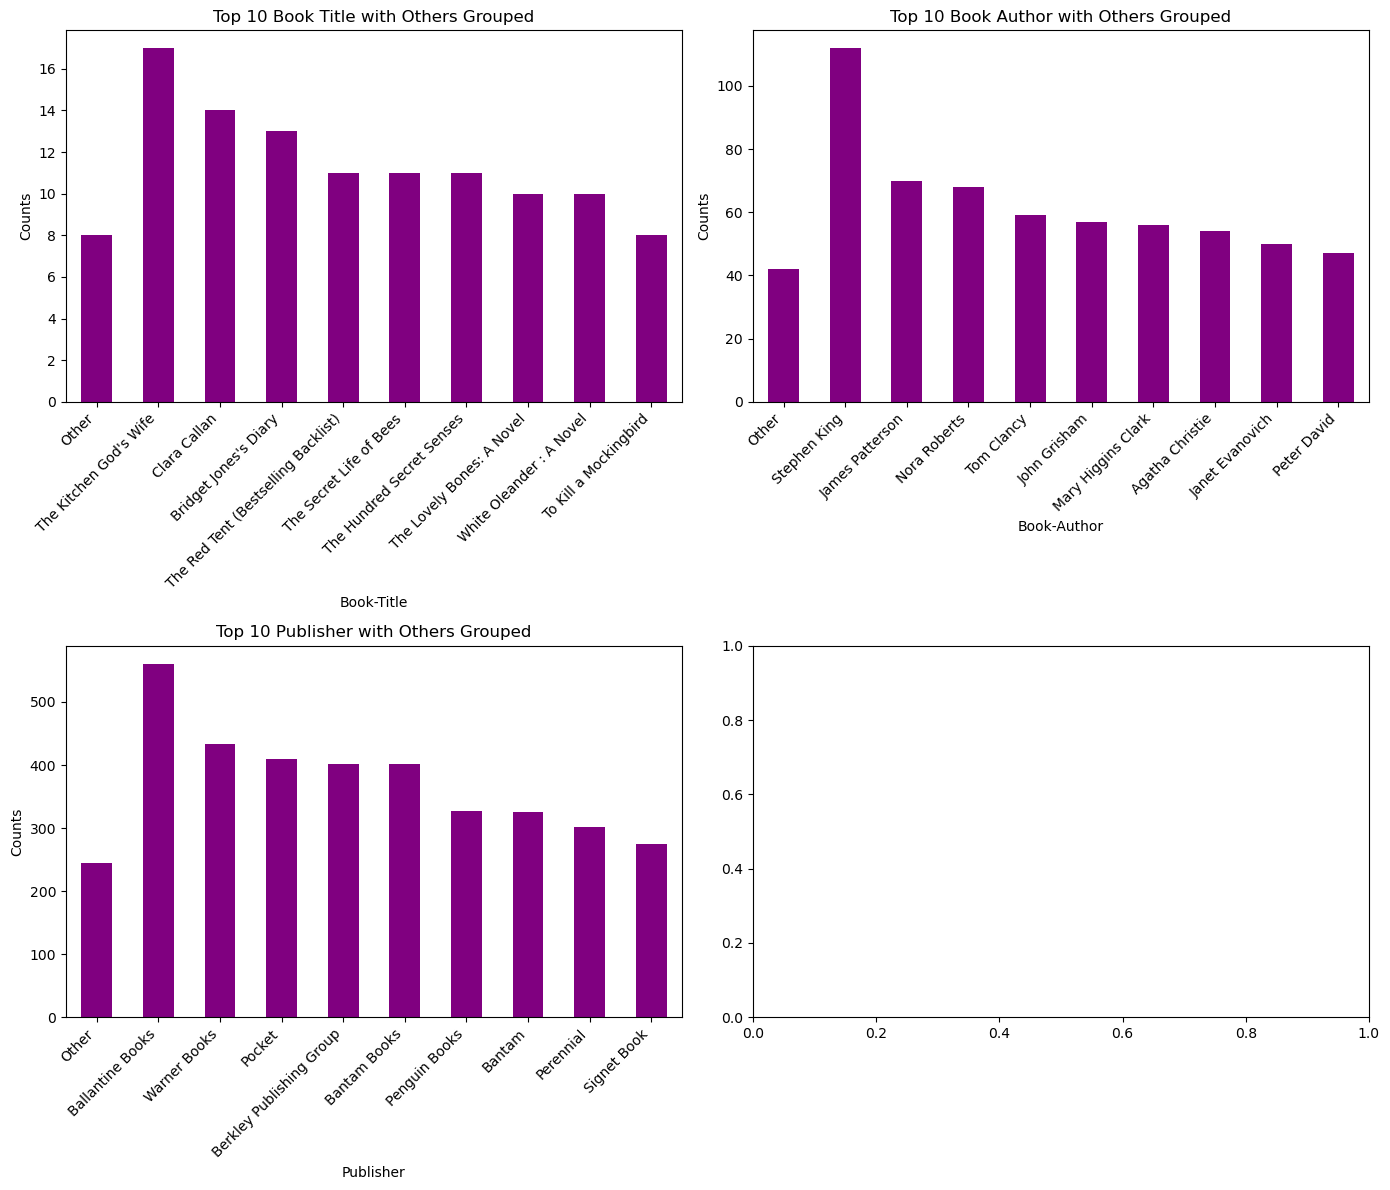

In [492]:
import matplotlib.pyplot as plt

# List of categorical columns
categories = ['Book-Title', 'Book-Author', 'Publisher']
top_n = 10
fig, axs = plt.subplots(2, 2, figsize=(14, 12))
for i, category in enumerate(categories):
    # Get the top N values and sum the rest as "Other"
    top_values = df[category].value_counts().nlargest(top_n)
    other_values = df[category].value_counts().iloc[top_n:].sum()
    top_values['Other'] = other_values
    
    # Plot the bar chart
    ax = axs[i // 2, i % 2]
    top_values.plot(kind='bar', ax=ax, color='purple')
    ax.set_title(f'Top 10 {category.replace("-", " ")} with Others Grouped')
    ax.set_ylabel('Counts')
    ax.set_xticklabels(top_values.index, rotation=45, ha='right')

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()


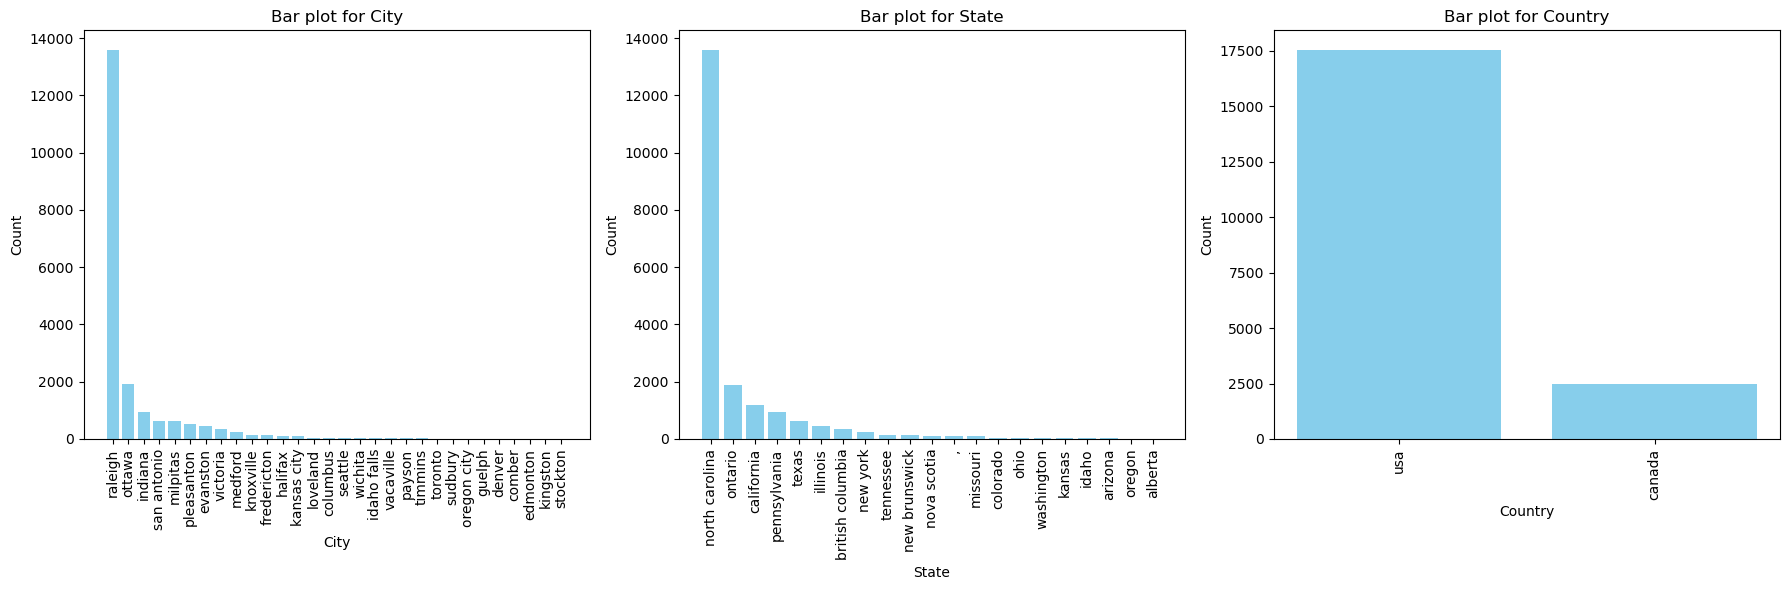

In [493]:
# Define the columns to plot
columns = ['City', 'State', 'Country']

# Set up subplots for side by side plots
fig, axs = plt.subplots(1, len(columns), figsize=(18, 6))  # Increase figsize to allow more space for x-axis

# Iterate through the list of columns and create bar plots
for i, column in enumerate(columns):
    counts = df[column].value_counts()
    axs[i].bar(counts.index, counts.values, color='skyblue')
    axs[i].set_title(f'Bar plot for {column}')
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('Count')
    axs[i].tick_params(axis='x', rotation=90, labelsize=10)  # Rotate x-axis labels to 90 degrees and set label size

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


# **Scaling Numerical Features and Encoding Categorical Features**

In [495]:
df.columns

Index(['Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Age',
       'City', 'State', 'Country'],
      dtype='object')

In [496]:
df_no_outliers.columns

Index(['Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Age',
       'City', 'State', 'Country'],
      dtype='object')

In [497]:
categorical_columns=df.select_dtypes(include=['object']).columns

In [498]:
for col in categorical_columns:
   df=pd.concat([df,pd.get_dummies(df[col],drop_first=True,prefix=col)],axis=1)
   df.drop(col,axis=1,inplace=True)

In [499]:
for col in categorical_columns:
   df_no_outliers=pd.concat([df_no_outliers,pd.get_dummies(df_no_outliers[col],drop_first=True,prefix=col)],axis=1)
   df_no_outliers.drop(col,axis=1,inplace=True)

In [500]:
for col in numerical_columns:
    scaler=MinMaxScaler()
    df_no_outliers[col]=scaler.fit_transform(df_no_outliers[[col]])

In [501]:
for col in numerical_columns:
    scaler=MinMaxScaler()
    df[col]=scaler.fit_transform(df[[col]])

In [502]:
df.head()

Year-Of-Publication   Age  Book-Title_Clara Callan  Book-Title_Other  \
0             0.971154  0.00                    False              True   
1             0.961538  0.28                     True             False   
2             0.865385  0.28                    False              True   
3             0.942308  0.28                    False              True   
4             0.942308  0.28                    False              True   

   Book-Title_The Bonesetter's Daughter  Book-Title_The Hundred Secret Senses  \
0                                 False                                 False   
1                                 False                                 False   
2                                 False                                 False   
3                                 False                                 False   
4                                 False                                 False   

   Book-Title_The Kitchen God's Wife  Book-Title_The Lovely Bones: A Novel  \
0                              False                                 False   
1                              False                                 False   
2                              False                                 False   
3                              False                                 False   
4                              False                                 False   

   Book-Title_The Red Tent (Bestselling Backlist)  \
0                                           False   
1                                           False   
2                                           False   
3                                           False   
4                                           False   

   Book-Title_The Secret Life of Bees  ...  State_north carolina  \
0                               False  ...                 False   
1                               False  ...                 False   
2                               False  ...                 False   
3                               False  ...                 False   
4                               False  ...                 False   

   State_nova scotia  State_ohio  State_ontario  State_oregon  \
0              False       False          False         False   
1              False       False           True         False   
2              False       False           True         False   
3              False       False           True         False   
4              False       False           True         False   

   State_pennsylvania  State_tennessee  State_texas  State_washington  \
0               False            False        False             False   
1               False            False        False             False   
2               False            False        False             False   
3               False            False        False             False   
4               False            False        False             False   

   Country_usa  
0         True  
1        False  
2        False  
3        False  
4        False  

[5 rows x 82 columns]

In [503]:
df_no_outliers.head()

Year-Of-Publication       Age  Book-Title_Clara Callan  Book-Title_Other  \
1             0.952941  0.428571                     True             False   
2             0.835294  0.428571                    False              True   
3             0.929412  0.428571                    False              True   
4             0.929412  0.428571                    False              True   
5             0.835294  0.428571                    False             False   

   Book-Title_The Bonesetter's Daughter  Book-Title_The Hundred Secret Senses  \
1                                 False                                 False   
2                                 False                                 False   
3                                 False                                 False   
4                                 False                                 False   
5                                 False                                 False   

   Book-Title_The Kitchen God's Wife  Book-Title_The Lovely Bones: A Novel  \
1                              False                                 False   
2                              False                                 False   
3                              False                                 False   
4                              False                                 False   
5                               True                                 False   

   Book-Title_The Red Tent (Bestselling Backlist)  \
1                                           False   
2                                           False   
3                                           False   
4                                           False   
5                                           False   

   Book-Title_The Secret Life of Bees  ...  State_colorado  State_idaho  \
1                               False  ...           False        False   
2                               False  ...           False        False   
3                               False  ...           False        False   
4                               False  ...           False        False   
5                               False  ...           False        False   

   State_new brunswick  State_north carolina  State_ohio  State_ontario  \
1                False                 False       False           True   
2                False                 False       False           True   
3                False                 False       False           True   
4                False                 False       False           True   
5                False                 False       False           True   

   State_tennessee  State_texas  State_washington  Country_usa  
1            False        False             False        False  
2            False        False             False        False  
3            False        False             False        False  
4            False        False             False        False  
5            False        False             False        False  

[5 rows x 66 columns]

# **Clustering Algorithms**

In [505]:
results = {
   
    'KMeans': {'clusters_with_outliers': [], 'clusters_without_outliers': [], 'silhouette_with_outliers': [], 'silhouette_without_outliers': []},
    'Agglomerative': {'clusters_with_outliers': [], 'clusters_without_outliers': [], 'silhouette_with_outliers': [], 'silhouette_without_outliers': []},
    'DBSCAN': {'clusters_with_outliers': [], 'clusters_without_outliers': [], 'silhouette_with_outliers': [], 'silhouette_without_outliers': []}
}


In [506]:

from sklearn.decomposition import PCA

# List of variance thresholds to check
variance_thresholds = [0.70, 0.75, 0.80, 0.85, 0.90, 0.95,0.98]

# Loop through each variance threshold and fit PCA
for variance in variance_thresholds:
    pca = PCA(n_components=variance)
    pca.fit(df)  # Fit PCA to the dataset
    
    # Print the number of components for the given variance
    print(f"Variance: {variance*100:.0f}% - Number of components: {pca.n_components_}")

Variance: 70% - Number of components: 6
Variance: 75% - Number of components: 7
Variance: 80% - Number of components: 10
Variance: 85% - Number of components: 13
Variance: 90% - Number of components: 17
Variance: 95% - Number of components: 22
Variance: 98% - Number of components: 31


In [507]:
pca=PCA(n_components=7)
reduced_data=pca.fit_transform(df)

In [508]:
dfn_pca = pd.DataFrame(reduced_data, columns=[f'pca{i+1}' for i in range(reduced_data.shape[1])])
dfn_pca.head()

pca1      pca2      pca3      pca4      pca5      pca6      pca7
0  0.806116  0.582568 -0.252686 -0.656882 -0.287346  0.000871 -0.085783
1  1.299432 -0.529076 -0.071871 -0.025093  0.018579  0.061477  0.177894
2  1.291135 -0.529442 -0.069823 -0.011462  0.014959  0.052881  0.161808
3  1.291722 -0.530200 -0.069405 -0.013573  0.014460  0.055004  0.161059
4  1.291722 -0.530200 -0.069405 -0.013573  0.014460  0.055004  0.161059

In [509]:
from sklearn.cluster import KMeans
ks=[i for i in range (2,10)]
wcss=[]
scores=[]
for k in ks:
    kmeans=KMeans(n_clusters=k)
    kmeans.fit(dfn_pca)
    wcss.append(kmeans.inertia_)
    scores.append(silhouette_score(dfn_pca,kmeans.labels_))


In [510]:
results_df=pd.DataFrame({'K':ks,'WCSS':wcss,'Silhouette_Score':scores})
results_df.head(20)

K          WCSS  Silhouette_Score
0  2  13006.012435          0.619934
1  3   9035.762681          0.679176
2  4   8003.701127          0.693610
3  5   5245.887052          0.781052
4  6   5029.887056          0.753793
5  7   2765.844502          0.837074
6  8   1815.896547          0.856539
7  9   1353.001151          0.862703

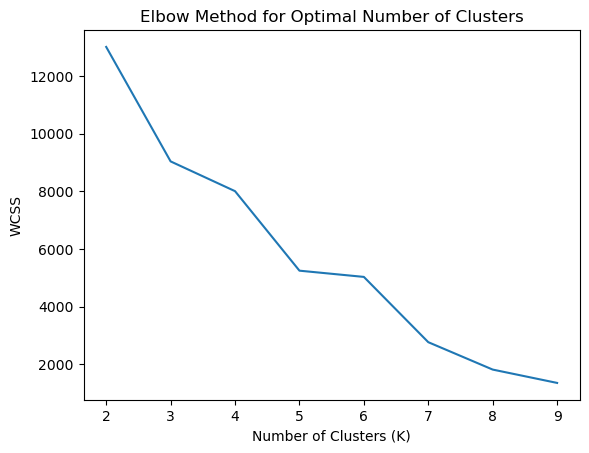

In [511]:
plt.plot(results_df['K'], results_df['WCSS'])
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.show()


In [512]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(dfn_pca)
results['KMeans']['clusters_with_outliers']=7
results['KMeans']['silhouette_with_outliers']=0.8662

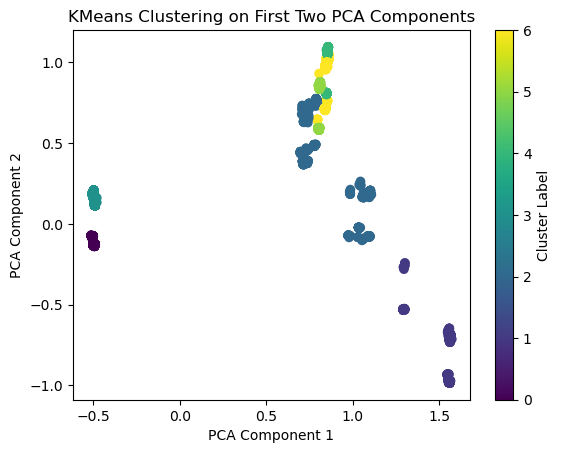

In [513]:
dfn_pca_values = dfn_pca.values 
# Plot the PCA components with KMeans labels
plt.scatter(dfn_pca_values[:, 0], dfn_pca_values[:, 1], c=kmeans.labels_, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('KMeans Clustering on First Two PCA Components')
plt.colorbar(label='Cluster Label')
plt.show()


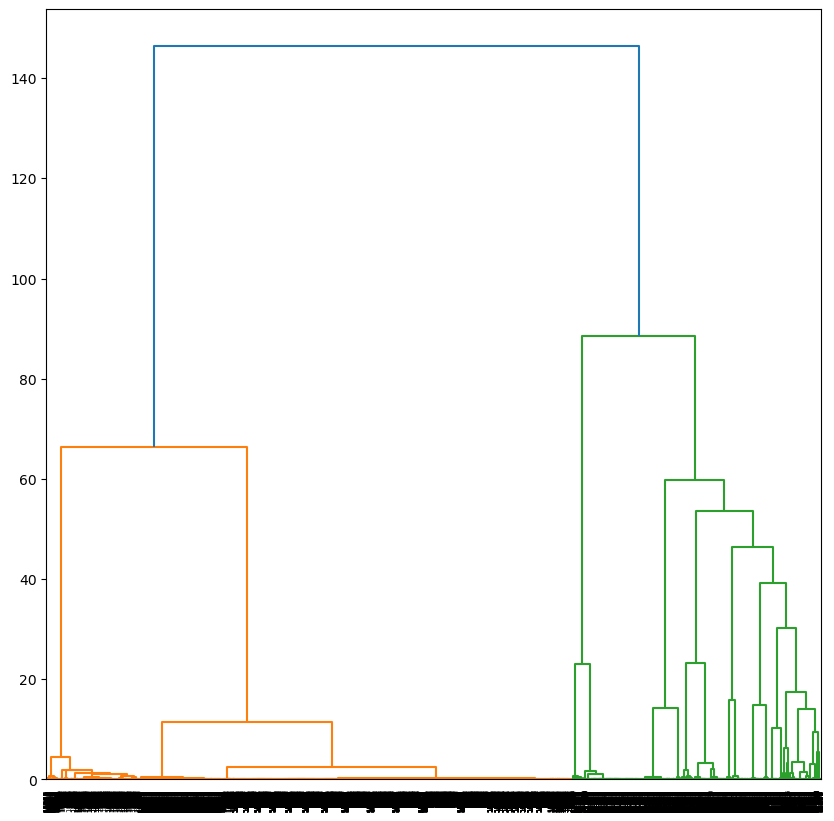

In [514]:
fig=plt.figure(figsize=(10,10))
link=linkage(dfn_pca,method='ward')
dendrogram(link)
plt.show()

In [515]:
cluster=AgglomerativeClustering(n_clusters=2,linkage='ward')
labels=cluster.fit_predict(dfn_pca)
print(silhouette_score(dfn_pca,labels))
results['Agglomerative']['clusters_with_outliers']=2
results['Agglomerative']['silhouette_with_outliers']=0.6199328175714048


0.6199335768772126


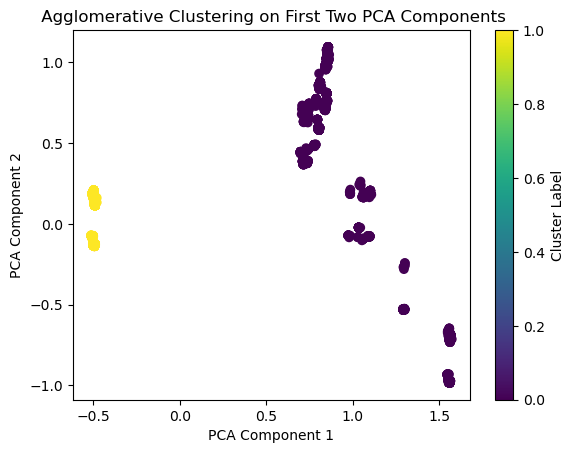

In [516]:
dfn_pca_values = dfn_pca.values 

# Plot the PCA components with KMeans labels
plt.scatter(dfn_pca_values[:, 0], dfn_pca_values[:, 1], c=labels, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title(' Agglomerative Clustering on First Two PCA Components')
plt.colorbar(label='Cluster Label')
plt.show()


In [517]:
#minpts=2d=14
#k=14-1=13


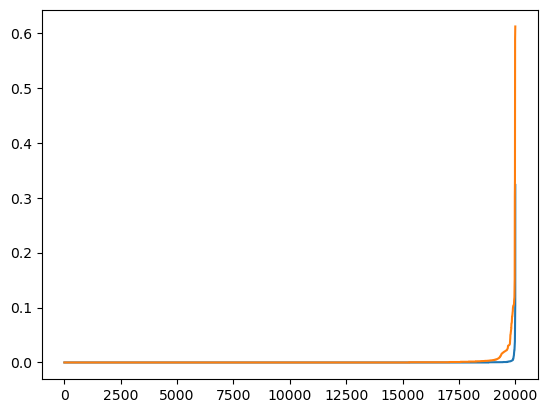

In [518]:
neigh=NearestNeighbors(n_neighbors=13)
nbrs=neigh.fit(dfn_pca)
distances,indices=nbrs.kneighbors(dfn_pca)
distances=np.sort(distances,axis=0)
distances1=distances[:,1]
distances2=distances[:,-1]
plt.plot(distances1)
plt.plot(distances2)
plt.show()


In [519]:

eps = [0.1, 0.12, 0.13, 0.14]  # Removed the incorrect "0.0"
min_samples = [i for i in range(13, 16, 1)]

scores = []
Is = []
Js = []
clusters = []

# Iterate over eps and min_samples values
for i in eps:
    for j in min_samples:
        dbscan = DBSCAN(eps=i, min_samples=j)
        dbscan.fit(dfn_pca)
        
        Is.append(i)
        Js.append(j)
        cluster_count = len(set(dbscan.labels_))
        clusters.append(cluster_count)
        
        # Check if there's only one cluster
        if cluster_count == 1:
            scores.append(-1)  # Invalid silhouette score for one cluster
        else:
            score = silhouette_score(dfn_pca, dbscan.labels_)
            scores.append(score)

# Displaying the results
for idx, (e, m, score, clust) in enumerate(zip(Is, Js, scores, clusters)):
    print(f"eps={e}, min_samples={m}, clusters={clust}, silhouette_score={score}")

  

eps=0.1, min_samples=13, clusters=30, silhouette_score=0.9113144881036964
eps=0.1, min_samples=14, clusters=30, silhouette_score=0.9110132182260053
eps=0.1, min_samples=15, clusters=30, silhouette_score=0.9107642760196589
eps=0.12, min_samples=13, clusters=27, silhouette_score=0.9185848908876334
eps=0.12, min_samples=14, clusters=27, silhouette_score=0.9185848908876334
eps=0.12, min_samples=15, clusters=27, silhouette_score=0.9185079960622392
eps=0.13, min_samples=13, clusters=26, silhouette_score=0.9230013883456782
eps=0.13, min_samples=14, clusters=26, silhouette_score=0.9230013883456782
eps=0.13, min_samples=15, clusters=26, silhouette_score=0.9230013883456782
eps=0.14, min_samples=13, clusters=26, silhouette_score=0.9230013883456782
eps=0.14, min_samples=14, clusters=26, silhouette_score=0.9230013883456782
eps=0.14, min_samples=15, clusters=26, silhouette_score=0.9230013883456782


In [520]:
results_df=pd.DataFrame({'eps':Is,'min_samples':Js,'Silhouette_Score':scores,'no clusters':clusters})
results_df

eps  min_samples  Silhouette_Score  no clusters
0   0.10           13          0.911314           30
1   0.10           14          0.911013           30
2   0.10           15          0.910764           30
3   0.12           13          0.918585           27
4   0.12           14          0.918585           27
5   0.12           15          0.918508           27
6   0.13           13          0.923001           26
7   0.13           14          0.923001           26
8   0.13           15          0.923001           26
9   0.14           13          0.923001           26
10  0.14           14          0.923001           26
11  0.14           15          0.923001           26

In [521]:
best=results_df[results_df['Silhouette_Score']==results_df['Silhouette_Score'].max()]
best

eps  min_samples  Silhouette_Score  no clusters
6   0.13           13          0.923001           26
7   0.13           14          0.923001           26
8   0.13           15          0.923001           26
9   0.14           13          0.923001           26
10  0.14           14          0.923001           26
11  0.14           15          0.923001           26

In [522]:
dbsca=DBSCAN(eps=0.14,min_samples=13)
results['DBSCAN']['clusters_with_outliers']=26
results['DBSCAN']['silhouette_with_outliers']=0.926
dbsca.fit_predict(dfn_pca)
dfn_pca['cluster']=dbsca.labels_
dfn_pca['cluster'].value_counts()

cluster
 3     9012
 18    2152
 4     2130
 1     1562
 16     845
 11     527
 20     497
 13     420
 24     381
 14     349
 22     312
 19     300
 2      282
 5      275
 23     148
 21     145
 12     108
 17     104
 8       97
 9       95
 7       83
 6       57
 0       43
 10      30
-1       27
 15      19
Name: count, dtype: int64

In [523]:
len(dfn_pca[dfn_pca['cluster']==-1])

27

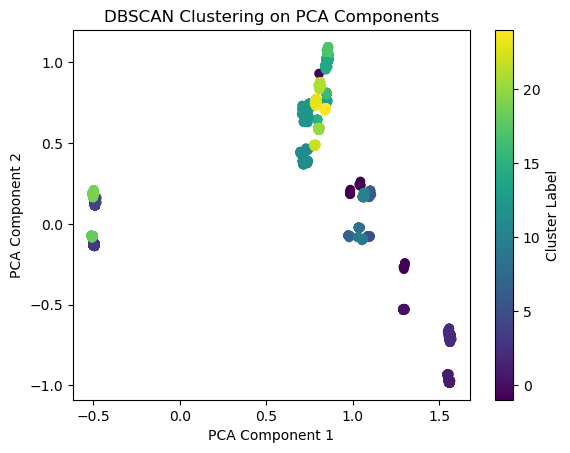

In [524]:
dfn_pca_values = dfn_pca.values 
# Plot the PCA components with KMeans labels
plt.scatter(dfn_pca_values[:, 0], dfn_pca_values[:, 1], c=dbsca.labels_, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('DBSCAN Clustering on PCA Components')
plt.colorbar(label='Cluster Label')
plt.show()

In [525]:
###without the otliers

In [526]:
from sklearn.decomposition import PCA

# List of variance thresholds to check
variance_thresholds = [0.70, 0.75, 0.80, 0.85, 0.90, 0.95,0.98]

# Loop through each variance threshold and fit PCA
for variance in variance_thresholds:
    pca = PCA(n_components=variance)
    pca.fit(df_no_outliers)  # Fit PCA to the dataset
    
    # Print the number of components for the given variance
    print(f"Variance: {variance*100:.0f}% - Number of components: {pca.n_components_}")

Variance: 70% - Number of components: 4
Variance: 75% - Number of components: 5
Variance: 80% - Number of components: 7
Variance: 85% - Number of components: 10
Variance: 90% - Number of components: 13
Variance: 95% - Number of components: 18
Variance: 98% - Number of components: 27


In [527]:
pca=PCA(n_components=5)
reduced_data=pca.fit_transform(df_no_outliers)

In [528]:
pca.explained_variance_ratio_

array([0.40286544, 0.14081467, 0.11201702, 0.06260719, 0.04048857])

In [529]:
dfn_pca_without_outliers = pd.DataFrame(reduced_data, columns=[f'pca{i+1}' for i in range(reduced_data.shape[1])])
dfn_pca_without_outliers.head()

pca1      pca2      pca3      pca4      pca5
0  1.361814 -0.315715 -0.096677  0.029023  0.187876
1  1.353043 -0.321363 -0.089687  0.031197  0.170525
2  1.353492 -0.322086 -0.090220  0.029120  0.171716
3  1.353492 -0.322086 -0.090220  0.029120  0.171716
4  1.360580 -0.312137 -0.097422  0.031368  0.185189

In [530]:
from sklearn.cluster import KMeans
ks=[i for i in range (2,10)]
wcss=[]
scores=[]
for k in ks:
    kmeans=KMeans(n_clusters=k)
    kmeans.fit(dfn_pca_without_outliers)
    wcss.append(kmeans.inertia_)
    scores.append(silhouette_score(dfn_pca_without_outliers,kmeans.labels_))


In [531]:
results_df=pd.DataFrame({'K':ks,'WCSS':wcss,'Silhouette_Score':scores})
results_df.head(20)

K          WCSS  Silhouette_Score
0  2  10325.637977          0.642364
1  3   7962.708707          0.653719
2  4   6101.451468          0.779802
3  5   2377.498756          0.876270
4  6   1244.370565          0.904047
5  7   1120.702357          0.911181
6  8    819.639263          0.902445
7  9    345.954774          0.945308

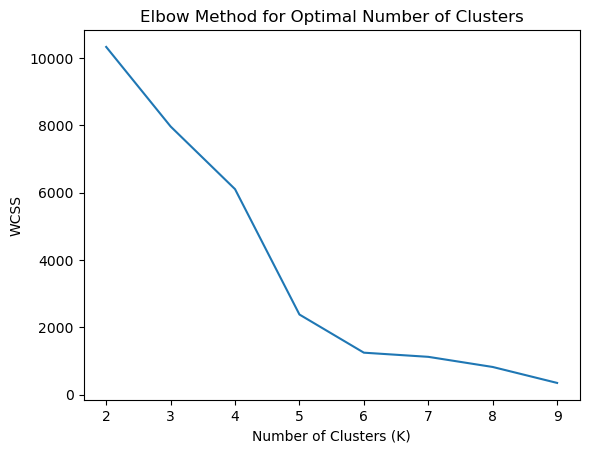

In [532]:
plt.plot(results_df['K'], results_df['WCSS'])
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.show()

In [533]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(dfn_pca_without_outliers)
results['KMeans']['clusters_without_outliers']=4
results['KMeans']['silhouette_without_outliers']=0.839546

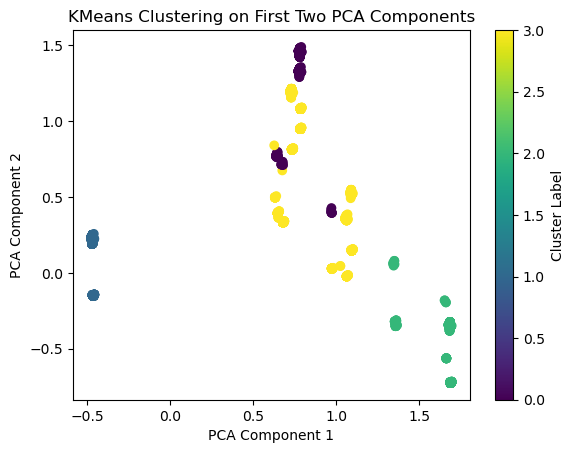

In [534]:
dfn_pca_values = dfn_pca_without_outliers.values 
# Plot the PCA components with KMeans labels
plt.scatter(dfn_pca_values[:, 0], dfn_pca_values[:, 1], c=kmeans.labels_, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('KMeans Clustering on First Two PCA Components')
plt.colorbar(label='Cluster Label')
plt.show()

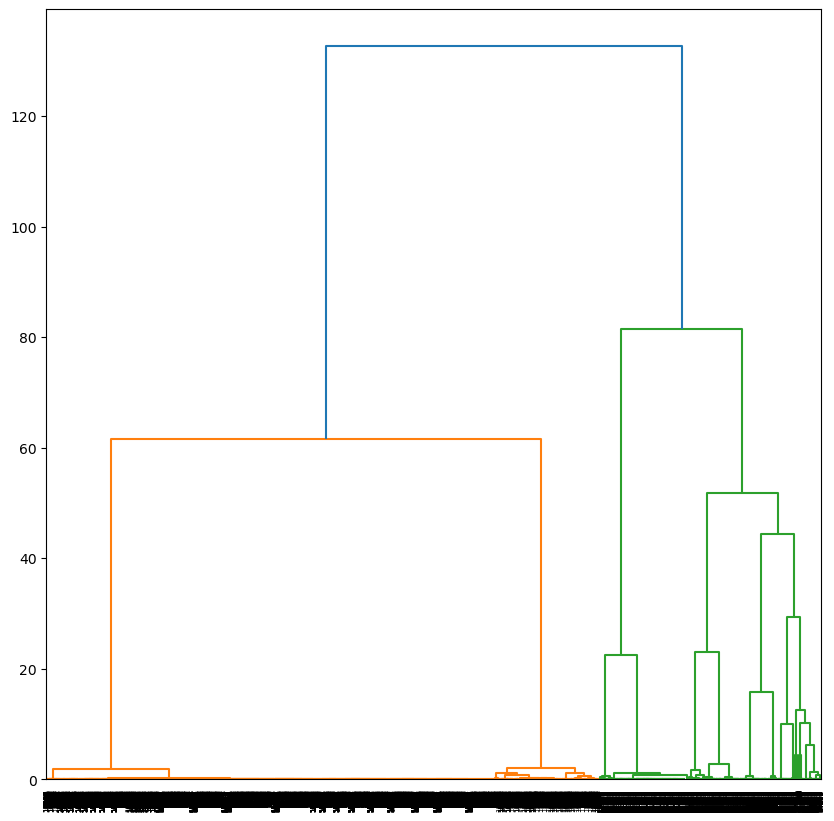

In [535]:
fig=plt.figure(figsize=(10,10))
link=linkage(dfn_pca_without_outliers,method='ward')
dendrogram(link)
plt.show()

In [536]:
cluster=AgglomerativeClustering(n_clusters=2,linkage='ward')
labels=cluster.fit_predict(dfn_pca_without_outliers)
print(silhouette_score(dfn_pca_without_outliers,labels))
results['Agglomerative']['clusters_without_outliers']=2
results['Agglomerative']['silhouette_without_outliers']=0.6202303839640595

0.6752434127379396


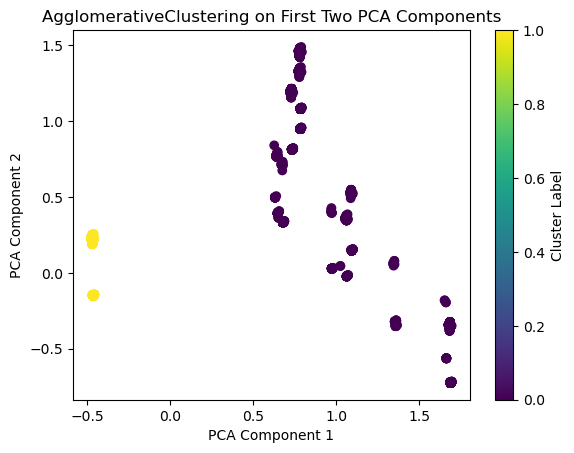

In [537]:
dfn_pca_values = dfn_pca_without_outliers.values 

# Plot the PCA components with KMeans labels
plt.scatter(dfn_pca_values[:, 0], dfn_pca_values[:, 1], c=labels, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('AgglomerativeClustering on First Two PCA Components')
plt.colorbar(label='Cluster Label')
plt.show()


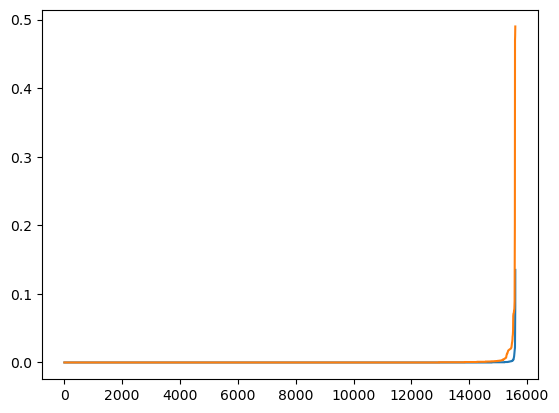

In [538]:
neigh=NearestNeighbors(n_neighbors=9)
nbrs=neigh.fit(dfn_pca_without_outliers)
distances,indices=nbrs.kneighbors(dfn_pca_without_outliers)
distances=np.sort(distances,axis=0)
distances1=distances[:,1]
distances2=distances[:,-1]
plt.plot(distances1)
plt.plot(distances2)
plt.show()

In [539]:
eps=[0.01,0.02,0.08,0.09,0.07]
min_samples=[i for i in range (9,12,1)]
scores=[]
Is=[]
Js=[]
clusters=[]
for i in eps:
    for j in min_samples:

      dbscan=DBSCAN(eps=i,min_samples=j)
      dbscan.fit(dfn_pca_without_outliers)
      Is.append(i)
      Js.append(j)
      clusters.append(len(set(dbscan.labels_)))
      if len(set(dbscan.labels_))==1:
        scores.append(-1)
      else:
        scores.append(silhouette_score(dfn_pca_without_outliers,dbscan.labels_))

In [540]:
results_df=pd.DataFrame({'eps':Is,'min_samples':Js,'Silhouette_Score':scores,'no clusters':clusters})
results_df

eps  min_samples  Silhouette_Score  no clusters
0   0.01            9          0.856579           71
1   0.01           10          0.863023           70
2   0.01           11          0.858100           66
3   0.02            9          0.903239           48
4   0.02           10          0.904800           45
5   0.02           11          0.903720           44
6   0.08            9          0.966249           21
7   0.08           10          0.966249           21
8   0.08           11          0.965958           21
9   0.09            9          0.966649           21
10  0.09           10          0.966649           21
11  0.09           11          0.966649           21
12  0.07            9          0.916379           24
13  0.07           10          0.916164           24
14  0.07           11          0.916164           24

In [541]:
best=results_df[results_df['Silhouette_Score']==results_df['Silhouette_Score'].max()]
best

eps  min_samples  Silhouette_Score  no clusters
9   0.09            9          0.966649           21
10  0.09           10          0.966649           21
11  0.09           11          0.966649           21

In [542]:
dbsca=DBSCAN(eps=0.09,min_samples=9)

dbsca.fit_predict(dfn_pca_without_outliers)


array([ 0,  0,  0, ..., 19, 19, 18], dtype=int64)

In [543]:
dfn_pca_without_outliers['cluster']=dbsca.labels_
dfn_pca_without_outliers['cluster'].value_counts()

cluster
 1     9012
 2     2130
 5     1500
 15     497
 11     420
 18     381
 3      275
 6      264
 13     224
 12     220
 16     145
 19     129
 8       93
 7       83
 4       57
 0       43
 14      35
 9       30
-1       22
 17      19
 10      14
Name: count, dtype: int64

In [544]:
len(dfn_pca_without_outliers[dfn_pca_without_outliers['cluster']==-1])
results['DBSCAN']['clusters_without_outliers']=21
results['DBSCAN']['silhouette_without_outliers']=0.967

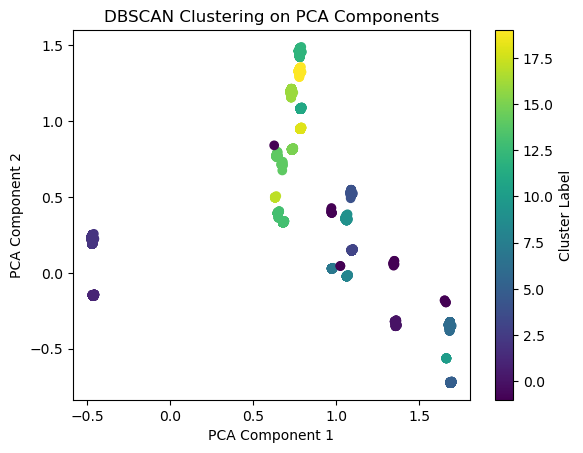

In [545]:
dfn_pca_values = dfn_pca_without_outliers.values 
# Plot the PCA components with KMeans labels
plt.scatter(dfn_pca_values[:, 0], dfn_pca_values[:, 1], c=dbsca.labels_, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('DBSCAN Clustering on PCA Components')
plt.colorbar(label='Cluster Label')
plt.show()

In [546]:
results

{'KMeans': {'clusters_with_outliers': 7,
  'clusters_without_outliers': 4,
  'silhouette_with_outliers': 0.8662,
  'silhouette_without_outliers': 0.839546},
 'Agglomerative': {'clusters_with_outliers': 2,
  'clusters_without_outliers': 2,
  'silhouette_with_outliers': 0.6199328175714048,
  'silhouette_without_outliers': 0.6202303839640595},
 'DBSCAN': {'clusters_with_outliers': 26,
  'clusters_without_outliers': 21,
  'silhouette_with_outliers': 0.926,
  'silhouette_without_outliers': 0.967}}

In [547]:
results_df = pd.DataFrame(results)

In [548]:
results_df

KMeans  Agglomerative  DBSCAN
clusters_with_outliers       7.000000       2.000000  26.000
clusters_without_outliers    4.000000       2.000000  21.000
silhouette_with_outliers     0.866200       0.619933   0.926
silhouette_without_outliers  0.839546       0.620230   0.967